In [4]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

data_dir = "/Users/martin.iniguez/Desktop/master-thesis/opm-thesis/data/digits_epochs/"
file = data_dir + "/freq_bands/all_data_all_epochs_decimated.pkl"
all_epochs = pickle.load(open(file, "rb"))


In [5]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 8
fmax = 60
freqs = np.arange(fmin, fmax + 1, 3)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr.pkl"):
    with open(data_dir + "all_epochs_tfr.pkl", "rb") as f:
        power = pickle.load(f)
else:

    power = {}
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power[str(idx + 1)] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )
    with open(data_dir + "all_epochs_tfr.pkl", "wb") as f:
        pickle.dump(power, f)

if os.path.exists(data_dir + "individual_epoch_tfr.pkl"):
    with open(data_dir + "individual_epoch_tfr.pkl", "rb") as f:
        power_per_epoch = pickle.load(f)

else:
    power_per_epoch = mne.time_frequency.tfr_morlet(
            all_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=5,
            return_itc=False,
            decim=3,
            average=False,
        )
    with open(data_dir + "individual_epoch_tfr.pkl", "wb") as f:
        pickle.dump(power_per_epoch, f)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done  67 tasks      | elapsed:   18.5s
[Parallel(n_jobs=5)]: Done 157 tasks      | elapsed:   41.6s
[Parallel(n_jobs=5)]: Done 188 out of 188 | elapsed:   49.4s finished


Not setting metadata


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


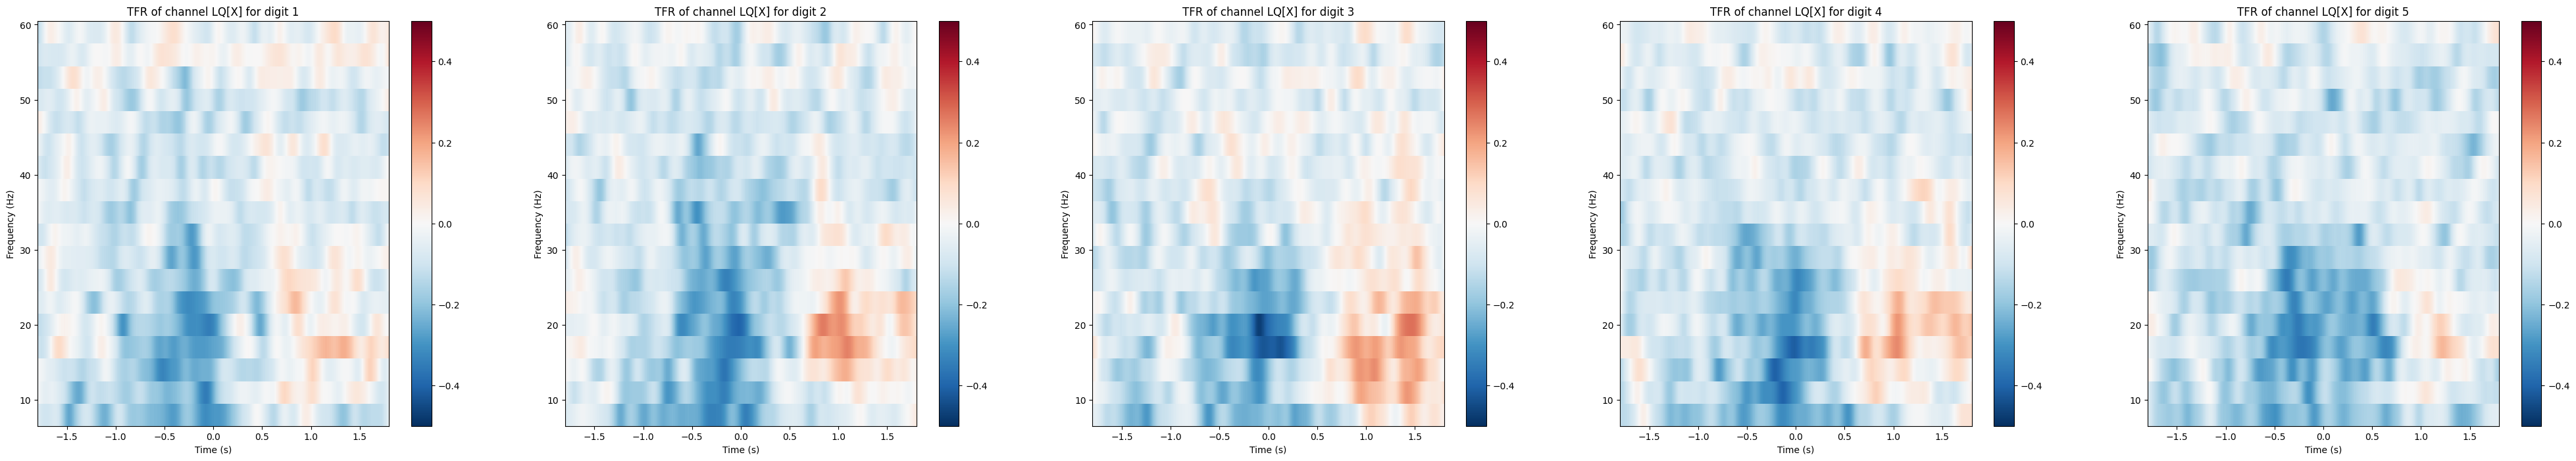

In [6]:
center_channel = "LQ[X]"
epochs = all_epochs.pick(center_channel)

conditions = [1, 2, 3, 4, 5]

# Create a figure with subplots
fig, axes = plt.subplots(
    1, len(conditions), figsize=(50, 8)
)  # Adjust figsize as needed

for i, condition in enumerate(conditions):
  # Select the subplot
  ax = axes[i]

  # Plot the 5 different digits in a subplot horziontally
  power[str(i+1)].plot(
      [epochs.ch_names.index(center_channel)],
      baseline=(-2, -0.57),
      mode="logratio",
      tmin=-1.8,
      tmax=1.8,
      axes = ax,
      show=False,
      vmin=-0.5,
      vmax=0.5,
  )
  ax.set_title("TFR of channel " + center_channel + " for digit " + str(i+1))

## Creating a classifier

In [11]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import TimeFreqCNN, MyDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

labels_to_use = [32, 128]
labels = all_epochs.events[:, -1]

valid_epochs_mask = np.isin(labels, labels_to_use)
data = power_per_epoch.data[valid_epochs_mask]
labels = labels[valid_epochs_mask]

label_mapping = {label: idx for idx, label in enumerate(labels_to_use)}
# Map the labels to 0 and 1
final_targets = np.array(
    [label_mapping[label] for label in labels if label in label_mapping]
)

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, final_targets, test_size=0.2, random_state=42
)

# Create PyTorch datasets and loaders
train_dataset = MyDataset(train_data, train_labels)
test_dataset = MyDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Train the classifier and evaluate it
classifier = TimeFreqCNN(
    len(labels_to_use), data.shape[1], data.shape[2], data.shape[3], device
)
classifier.train_model(train_loader, num_epochs=100, learning_rate=1e-3)
classifier.evaluate(test_loader)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 1, 188, 18, 401]